# Se importan las librerias

In [1]:
import pandas as pd
import seaborn as sns
from sklearn.neighbors import KernelDensity
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import MinMaxScaler
from scipy.optimize import minimize
import re
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
import warnings
warnings.filterwarnings('ignore')
import nltk
from gensim.models import Word2Vec

# Se descarga el recurso 'punkt' para tokenizar o separar palabras
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Se importa el archivo "meta_google_miami.parquet" que está asociado a 800 restaurantes de Miami filtrados

In [2]:
meta=pd.read_parquet("meta_google_miami.parquet")

# Se importa el archivo "data_filtrada.parquet" que posee un gran conjunto de palabras útiles para entrenar el modelo

In [3]:
meta_1=pd.read_parquet("data_filtrada.parquet")

# Se guardan las categorías únicas

In [4]:
categorias_existentes = meta_1['category'].unique()

# Se utiliza el algoritmo KernelDensity que busca la densidad en la coordenadas de los restaurantes

In [5]:
# Se obtienen las coordenadas de todos los restaurantes
coordenadas = meta[['latitude', 'longitude']].values

# Se inicializa el modelo de Kernel Density Estimation (KDE)
kde = KernelDensity(bandwidth=0.01, metric='haversine')

# Se ajusta el modelo a las coordenadas de los restaurantes
kde.fit(np.radians(coordenadas))

# Se calcula las densidades para todas las coordenadas de los restaurantes
densidades = kde.score_samples(np.radians(coordenadas))

# Se agregan la columna de densidad al DataFrame "meta"
meta['densidad'] = densidades


In [14]:
categorias_existentes = meta_1['category'].unique()
categorias_existentes.shape

(34200,)

# Se muestran las categorías del dataset

In [6]:
categorias_existentes

array(['Korean restaurant', 'Restaurant',
       'Bakery, Health food restaurant', ...,
       'Bar & grill, Convenience store, Lottery retailer, Pizza delivery, Propane supplier, Sandwich shop',
       'Brazilian restaurant, Bistro, Brazilian pastelaria, Diner, Fast food restaurant, Pub, Restaurant',
       'Mexican restaurant, Bar, Pub, Restaurant'], dtype=object)

# Se entrena un modelo de búsqueda de palabras similares llamado Word2Vec

In [7]:
# Se limpia las comas y espacios en blanco en las categorías antes de tokenizar
categorias_limpio = [re.sub(r'[^\w\s]', '', category) for category in categorias_existentes]
categorias_tokenizadas = [word_tokenize(category) for category in categorias_limpio]

# Se entrena el modelo Word2Vec en las categorías tokenizadas
model = Word2Vec(categorias_tokenizadas, vector_size=300, window=5, min_count=5, sg=0)

# Se guarda el modelo entrenado con el dataset

In [8]:
model.save("modelo_word2vec.bin")

# Se prueba el algoritmo entrenado

In [9]:
# Se obtiene la palabra ingresada por el usuario
palabra = input("Ingresa una palabra: ")

# Se limpia la palabra ingresada por el usuario
palabra = re.sub(r'[^\w\s]', '', palabra)

# Se entrena la palabra más cercana según la similitud del coseno
try:
    palabra_similar, similaridad = model.wv.most_similar(palabra, topn=1)[0]
    print(f"La palabra más cercana a '{palabra}' es '{palabra_similar}' con una similitud de coseno de {similaridad:.2f}")

    # Se filtra las categorías que contienen la palabra similar
    categorias_con_palabra = [categoria for categoria in categorias_existentes if palabra_similar in categoria]

    # Se filtra el DataFrame 'meta' por las categorías encontradas

    meta_filtro = meta[meta['category'].isin(categorias_con_palabra)]

except KeyError:
    print(f"'{palabra}' no está en el vocabulario.")


Ingresa una palabra: Mexican
La palabra más cercana a 'Mexican' es 'Taco' con una similitud de coseno de 0.87


## Se utiliza el algoritmo entrenado para mostrar los restaurantes más recomendados, utilizando la optimización de una suma ponderada, que vincula las características "densidad" "puntaje" y "número de reviews" con el metodo del descenso del gradiente

# Función a optimizar:

### puntuación restaurante = peso_puntaje * puntaje_normalizado + peso_densidad * densidad_normalizada + peso_nºreviews * nº_reviews_normalizado

In [15]:
# Pesos en el rango [0, 1]
initial_weights = [0.25, 0.25, 0.25]  # Valores iniciales de los pesos

# Se normalizan las columnas de puntuación, densidad y número de revisiones entre 0 y 1
scaler = MinMaxScaler()
meta_filtro['puntaje_normalizado'] = scaler.fit_transform(meta_filtro[['avg_rating']])
meta_filtro['densidad_normalizada'] = scaler.fit_transform(meta_filtro[['densidad']])
meta_filtro['num_of_reviews_normalizado'] = scaler.fit_transform(meta_filtro[['num_of_reviews']])

# Se define la función objetivo para minimizar
def objective_function(weights):
    puntuacion_restaurante = (
        weights[0] * meta_filtro['densidad_normalizada'] +
        weights[1] * meta_filtro['puntaje_normalizado'] +
        weights[2] * meta_filtro['num_of_reviews_normalizado']
    )
    return -puntuacion_restaurante.sum()

# Devuelve la suma negativa de la puntuación total que es equivalente que es equivalente a haber buscado el máximo

# Se definen las restricciones de los pesos (en este caso, todos estánr entre 0 y 1)
constraints = [{'type': 'ineq', 'fun': lambda w: w[i]} for i in range(len(initial_weights))]

# Se optimizan los pesos usando el algoritmo de Descenso del Gradiente
result = minimize(objective_function, initial_weights, constraints=constraints)

# Se obtienen los pesos optimizados
optimized_weights = result.x

# Se calcula la puntuacion_restaurante con los pesos optimizados
meta_filtro['puntuacion_restaurante'] = (
    optimized_weights[0] * meta_filtro['densidad_normalizada'] +
    optimized_weights[1] * meta_filtro['puntaje_normalizado'] +
    optimized_weights[2] * meta_filtro['num_of_reviews_normalizado']
)

# Ordena el DataFrame en función de la puntuación restaurante en orden decreciente
meta_ordenado = meta_filtro.sort_values(by='puntuacion_restaurante', ascending=False)

In [16]:
meta_ordenado[["name","category"]].head()

,name,category
116766,Pilo's Tequila Garden,"Bar, Mexican restaurant, Taco restaurant"
112915,El Primo Red Tacos,Taco restaurant
112921,Que Hubo Parce,"Colombian restaurant, Fast food restaurant, La..."
84868,LST @ TW,"Mexican restaurant, Catering food and drink su..."
35909,SoCal Cantina South Beach,Taco restaurant


# Se muestra el orden de importancia para cada característica

In [17]:
# Nombres de las características correspondientes
nombres = ['densidad', 'puntaje_normalizado', 'num_of_reviews']

# Crea un diccionario que asocie las características con sus pesos optimizados
dic = {nombres[i]: optimized_weights[i] for i in range(len(nombres))}

# Imprime el diccionario para ver el orden de importancia
print(dic)

{'densidad': 2.4658180596874778e+32, 'puntaje_normalizado': 1.5616223508543278e+32, 'num_of_reviews': 1.3974333125330806e+32}


# Es importante observar como el orden de iportancia de las características varía de acuerdo a la elección de palabra hecha por el usuario

# Se corrobora la independencia de las características utilizadas. Esto es importante para descartar características que puedan estar de más y sesgar el modelo

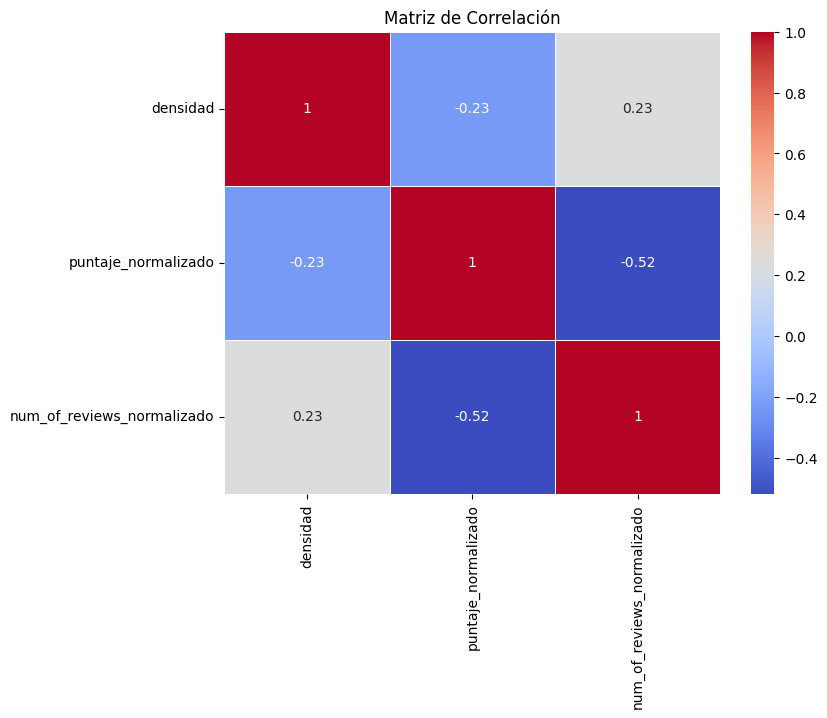

In [18]:
# Se calcula la matriz de correlación
corr = meta_filtro[['densidad', 'puntaje_normalizado', 'num_of_reviews_normalizado']].corr()

# Se crea un mapa de calor (heatmap) para visualizar la matriz de correlación
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Matriz de Correlación')
plt.show()

# Se observa la correlación entre la puntuación de los restaurantes filtrados y cada característica usada

In [19]:
# Calcula las correlaciones entre "puntuacion_restaurante" y las tres columnas normalizadas
correlation_puntaje = meta_filtro['puntuacion_restaurante'].corr(meta_filtro['puntaje_normalizado'])
correlation_densidad = meta_filtro['puntuacion_restaurante'].corr(meta_filtro['densidad_normalizada'])
correlation_reviews = meta_filtro['puntuacion_restaurante'].corr(meta_filtro['num_of_reviews_normalizado'])

print(f"Correlación entre Puntuación del Restaurante y Puntaje Normalizado: {correlation_puntaje}")
print(f"Correlación entre Puntuación del Restaurante y Densidad Normalizada: {correlation_densidad}")
print(f"Correlación entre Puntuación del Restaurante y Número de Reseñas Normalizado: {correlation_reviews}")


Correlación entre Puntuación del Restaurante y Puntaje Normalizado: 0.01663719819878325
Correlación entre Puntuación del Restaurante y Densidad Normalizada: 0.8834969251645014
Correlación entre Puntuación del Restaurante y Número de Reseñas Normalizado: 0.4462991322479971


In [31]:
from geopy.distance import geodesic

# Obtener la entrada del usuario
nombre_ingresado = input("Ingrese el nombre del lugar: ")

# Filtrar los datos para obtener solo los restaurantes dentro del radio de 500 metros
restaurantes_cercanos = meta_1.copy()

# Definir las coordenadas del lugar ingresado por el usuario
latitud_usuario = restaurantes_cercanos[restaurantes_cercanos['name'] == nombre_ingresado]['latitude'].iloc[0]
longitud_usuario = restaurantes_cercanos[restaurantes_cercanos['name'] == nombre_ingresado]['longitude'].iloc[0]

# Calcular la distancia a cada restaurante en metros y agregarla como una nueva columna
restaurantes_cercanos['Distancia (m)'] = restaurantes_cercanos.apply(
    lambda row: geodesic((latitud_usuario, longitud_usuario), (row['latitude'], row['longitude'])).meters, axis=1
)

# Convertir la distancia límite a un valor numérico (en metros)
distancia_limite_metros = 1000

# Filtrar los restaurantes dentro del radio de 500 metros y con la misma categoría
restaurantes_cercanos = restaurantes_cercanos[
    (restaurantes_cercanos['Distancia (m)'] <= distancia_limite_metros)
]

# Ordenar los restaurantes por distancia
restaurantes_cercanos = restaurantes_cercanos.sort_values(by='Distancia (m)')


Ingrese el nombre del lugar: Pilo's Tequila Garden


In [32]:
restaurantes_cercanos.head()

,name,address,gmap_id,latitude,longitude,category,avg_rating,num_of_reviews,MISC,state,Distancia (m)
116766,Pilo's Tequila Garden,"Pilo's Tequila Garden, 158 NW 24th St, Miami, ...",0x88d9b74278e90063:0xc321f3dc07e124a9,25.799685,-80.197946,"Bar, Mexican restaurant, Taco restaurant",4.3,98,{'Accessibility': ['Wheelchair accessible entr...,Florida,0.000000
18914,Conos Miami,"Conos Miami, 150 NW 24th St, Miami, FL 33127",0x88d9b5d6e8db4665:0x817cd680a5eb94e,25.799701,-80.197837,Restaurant,4.9,97,{'Accessibility': ['Wheelchair accessible entr...,Florida,11.065322
109199,Nostimo Greek Kitchen,"Nostimo Greek Kitchen, 170 NW 24th St, Miami, ...",0x88d9b78823b3f52d:0xaf75ef38e0bc9bcb,25.799593,-80.198170,"Greek restaurant, Falafel restaurant, Family r...",4.7,138,{'Accessibility': ['Wheelchair accessible entr...,Florida,24.700303
96846,1-800-Lucky,"1-800-Lucky, 143 NW 23rd St, Miami, FL 33127, ...",0x88d9b6adee2091ad:0x96c8a82bb0944c96,25.799374,-80.197964,Asian restaurant,4.5,2396,{'Accessibility': ['Wheelchair-accessible entr...,Florida,34.502957
41184,B-Side by Itamae,"B-Side by Itamae, 143 NW 23rd St Inside 1-800-...",0x88d9b7d1e09155a1:0xd58fcd475f989eef,25.799365,-80.197946,"Sushi restaurant, Japanese restaurant",4.2,8,{'Accessibility': ['Wheelchair accessible entr...,Florida,35.473335
